In [1]:
import os
import random
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff
import json
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [2]:
def load_3d_images_from_directory(directory, tag='img'):
    image_files = [f for f in os.listdir(directory) if f.startswith(tag) and f.endswith('.nii.gz')]
    image_files.sort()

    images = []
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        img = nib.load(img_path).get_fdata()
        images.append(img[np.newaxis, ..., np.newaxis])

    # Stack all images into a numpy array with shape (N, D, H, W)
    x_data = np.stack(images, axis=0)
    x_data = x_data.astype(np.float32)
    return x_data

directory = 'Dataset_HW4/test'
x_test = load_3d_images_from_directory(directory, tag = 'img')
x_test_seg = load_3d_images_from_directory(directory, tag = 'seg')

In [3]:
def dice_coefficient(pred, target):
    dice_scores = []

    for label in range(1, 36):  # Start from 1 to exclude 0 (background)
        pred_mask = (pred == label).astype(np.float32)
        target_mask = (target == label).astype(np.float32)
        
        # Calculate intersection and sum of masks
        intersection = np.sum(pred_mask * target_mask)
        union = np.sum(pred_mask) + np.sum(target_mask)
    
        dice = (2 * intersection) / (union)
        dice_scores.append(dice)
    
    return dice_scores

In [4]:
def hausdorff_distance(pred, target, max_value=100):
    hausdorff_distances = []
    
    for label in range(1, 36):  # Start from 1 to exclude 0 (background)
        pred_coords = np.argwhere(pred == label)
        target_coords = np.argwhere(target == label)

        if len(pred_coords) == 0 or len(target_coords) == 0:
            hausdorff_distances.append(max_value)
            continue

        d1 = directed_hausdorff(pred_coords, target_coords)[0]
        d2 = directed_hausdorff(target_coords, pred_coords)[0]
        hausdorff_distances.append(max(d1, d2))
    
    return hausdorff_distances

In [5]:
vol_shape = x_test[0][0, ..., 0].shape
print(f'vol_shape = {vol_shape}')
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

vol_shape = (160, 192, 224)


In [6]:
vxm_model.load_weights('vxm_ssd.h5')

metrics_per_class = {}
N = x_test.shape[0]

for i in range(N):
    for j in range(N):
        if i!=j:
            y, disp = vxm_model.predict([x_test[i],x_test[j]])
            warped_seg = warp_model.predict([x_test_seg[i], disp])  
            
            dice_before_reg = dice_coefficient(x_test_seg[i][0, ..., 0], x_test_seg[j][0, ..., 0])
            dice_reg = dice_coefficient(warped_seg[0, ..., 0], x_test_seg[j][0, ..., 0])
            hd_before_reg = hausdorff_distance(x_test_seg[i][0, ..., 0], x_test_seg[j][0, ..., 0])
            hd_reg = hausdorff_distance(warped_seg[0, ..., 0], x_test_seg[j][0, ..., 0])
            
            metrics_per_class[f'{i},{j}'] = {"dice_before_reg": dice_before_reg, "dice_reg": dice_reg, "hd_before_reg": hd_before_reg, "hd_reg": hd_reg}
            
with open('vxm_ssd.json', 'w') as f:
    json.dump(metrics_per_class, f)

print('Saved results')

Saved results


In [7]:
vxm_model.load_weights('vxm_ncc.h5')

metrics_per_class = {}
N = x_test.shape[0]

for i in range(N):
    for j in range(N):
        if i!=j:
            y, disp = vxm_model.predict([x_test[i],x_test[j]])
            warped_seg = warp_model.predict([x_test_seg[i], disp])  
            
            dice_before_reg = dice_coefficient(x_test_seg[i][0, ..., 0], x_test_seg[j][0, ..., 0])
            dice_reg = dice_coefficient(warped_seg[0, ..., 0], x_test_seg[j][0, ..., 0])
            hd_before_reg = hausdorff_distance(x_test_seg[i][0, ..., 0], x_test_seg[j][0, ..., 0])
            hd_reg = hausdorff_distance(warped_seg[0, ..., 0], x_test_seg[j][0, ..., 0])
            
            metrics_per_class[f'{i},{j}'] = {"dice_before_reg": dice_before_reg, "dice_reg": dice_reg, "hd_before_reg": hd_before_reg, "hd_reg": hd_reg}
            
with open('vxm_ncc.json', 'w') as f:
    json.dump(metrics_per_class, f)
    
print('Saved results')

Saved results


### Example input and output for the model

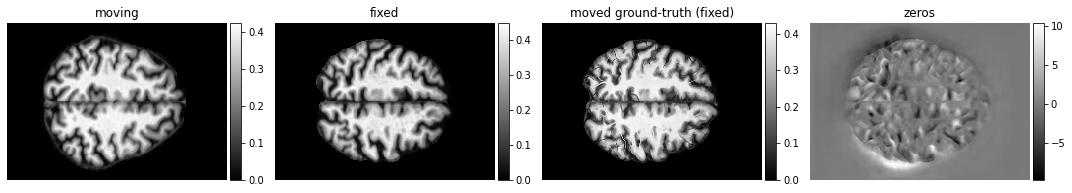

In [8]:
in_sample = [x_test[5],x_test[9]]
out_sample = vxm_model.predict(in_sample)
images = [img[0, :,50, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [14]:
import SimpleITK as sitk
image = sitk.ReadImage("Dataset_HW4/test/img0438.nii.gz")
voxel_spacing = image.GetSpacing()
print("Voxel Spacing (x, y, z):", voxel_spacing)

Voxel Spacing (x, y, z): (1.0, 1.0, 1.0)


#### As the voxel spacing is 1mm x 1mm x 1mm, hausdorff distance in pixels is equal to hausdorff distance in mm as the input images are in the original size.